In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from geopy.distance import geodesic

In [2]:
df = pd.read_csv("refined_df.csv")
df = df.drop("Unnamed: 0", axis=1)
df.head()

,Shipments: Attributes Ocean type category,Shipments: Attributes Shipment ID,Shipments: Attributes Tradelane,Shipments: Attributes Gross Weight (kg),Shipments: Attributes Volume (cbm),Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Attributes Freight Type,Shipments: Locations Arrival port Coordinates,Shipments: Locations Departure port Coordinates,Port pair,Total Actual Days
0,coloaded_lcl,3051512,TAWB,323,2.622,160.13,358.66,Port to Door,"32.7764749,-79.93105120000001","53.5510846,9.9936819",DEHAM - USATL,70.0
1,coloaded_lcl,3065451,TAWB,490,0.538,30.83,346.84,Door to Door,"45.5016889,-73.567256","53.5510846,9.9936819",DEHAM - USCHI,45.0
2,coloaded_lcl,3022941,TPEB,"1,913",11.360,54.37,233.94,Port to Door,"34.0522342,-118.2436849","22.356851,91.7831819",BDCGP - USLAX,57.0
3,coloaded_lcl,3024506,FEWB,752,0.508,147.02,421.03,Door to Door,"51.961726,1.351255","18.9499361,72.9511875",INNSA - GBFXT,57.0
4,flxt_lcl,3055002,TPEB,"6,471",8.110,"1,793.56",296.68,Port to Door,"34.0522342,-118.2436849","22.6272784,120.3014353",TWKHH - USLAX,43.0


In [3]:
df[['dest_latitude', 'dest_longitude']] = df['Shipments: Locations Arrival port Coordinates'] \
    .str.split(',', expand=True).astype(float)
df[['org_latitude', 'org_longitude']] = df['Shipments: Locations Departure port Coordinates'] \
    .str.split(',', expand=True).astype(float)
df = df.drop(["Shipments: Locations Arrival port Coordinates","Shipments: Locations Departure port Coordinates"], axis=1)


In [4]:
cols_to_convert = [
    'Shipments: Attributes Gross Weight (kg)', 
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km'
]

# Remove commas and convert to float
df[cols_to_convert] = df[cols_to_convert].replace(',', '', regex=True).astype(float)


In [5]:
df.head()

,Shipments: Attributes Ocean type category,Shipments: Attributes Shipment ID,Shipments: Attributes Tradelane,Shipments: Attributes Gross Weight (kg),Shipments: Attributes Volume (cbm),Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Attributes Freight Type,Port pair,Total Actual Days,dest_latitude,dest_longitude,org_latitude,org_longitude
0,coloaded_lcl,3051512,TAWB,323.0,2.622,160.13,358.66,Port to Door,DEHAM - USATL,70.0,32.776475,-79.931051,53.551085,9.993682
1,coloaded_lcl,3065451,TAWB,490.0,0.538,30.83,346.84,Door to Door,DEHAM - USCHI,45.0,45.501689,-73.567256,53.551085,9.993682
2,coloaded_lcl,3022941,TPEB,1913.0,11.360,54.37,233.94,Port to Door,BDCGP - USLAX,57.0,34.052234,-118.243685,22.356851,91.783182
3,coloaded_lcl,3024506,FEWB,752.0,0.508,147.02,421.03,Door to Door,INNSA - GBFXT,57.0,51.961726,1.351255,18.949936,72.951188
4,flxt_lcl,3055002,TPEB,6471.0,8.110,1793.56,296.68,Port to Door,TWKHH - USLAX,43.0,34.052234,-118.243685,22.627278,120.301435


In [6]:
# 1. Filter TPEB data
tpeb_df = df[df['Shipments: Attributes Tradelane'] == 'TPEB'].copy()

# 2. Feature Engineering
# Weight-to-volume ratio
tpeb_df['Weight_to_Volume'] = tpeb_df['Shipments: Attributes Gross Weight (kg)'] / (tpeb_df['Shipments: Attributes Volume (cbm)'] + 1e-6)

# Total shipment distance (km + converted miles)
tpeb_df['Total_Shipment_Distance_km'] = tpeb_df['Shipment Containers: Distance Origin to First Port Distance in km'] + (tpeb_df['Shipment Containers: Distance Final Port to Destination Distance in mile'] * 1.60934)

# Split port pair into origin and destination
tpeb_df[['Origin Port', 'Destination Port']] = tpeb_df['Port pair'].str.split(' - ', expand=True)


tpeb_df['Geo Distance'] = tpeb_df.apply(
    lambda row: geodesic(
        (row['org_latitude'], row['org_longitude']), 
        (row['dest_latitude'], row['dest_longitude'])
    ).km, axis=1
)

# Drop unused or now redundant columns
tpeb_df.drop([
    "Shipments: Attributes Tradelane", "Port pair",
    "Shipments: Attributes Gross Weight (kg)",
    "Shipments: Attributes Volume (cbm)"
], axis=1, inplace=True)



In [7]:
tpeb_df = tpeb_df.dropna()
tpeb_df.to_csv("tpeb.csv")
tpeb_df.head()

,Shipments: Attributes Ocean type category,Shipments: Attributes Shipment ID,Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Attributes Freight Type,Total Actual Days,dest_latitude,dest_longitude,org_latitude,org_longitude,Weight_to_Volume,Total_Shipment_Distance_km,Origin Port,Destination Port,Geo Distance
2,coloaded_lcl,3022941,54.37,233.94,Port to Door,57.0,34.052234,-118.243685,22.356851,91.783182,168.397873,321.439816,BDCGP,USLAX,13003.788261
4,flxt_lcl,3055002,1793.56,296.68,Port to Door,43.0,34.052234,-118.243685,22.627278,120.301435,797.903724,3183.127850,TWKHH,USLAX,11203.015045
9,coloaded_lcl,3021482,54.37,230.96,Port to Door,79.0,34.052234,-118.243685,22.356851,91.783182,185.529075,318.459816,BDCGP,USLAX,13003.788261
12,coloaded_lcl,3053937,1833.99,7.25,Port to Door,77.0,34.052234,-118.243685,10.823099,106.629664,151.164063,2958.763467,VNSGN,USLAX,13151.722926
14,flxt_lcl,2976454,9.93,45.30,Port to Door,37.0,34.052234,-118.243685,22.627278,120.301435,652.695684,61.280746,TWKHH,USLAX,11203.015045


In [8]:
tpeb_df['Speed_km_per_day'] = tpeb_df['Geo Distance'] / (tpeb_df['Total Actual Days'] + 1e-6)
tpeb_df['Efficiency'] = tpeb_df['Weight_to_Volume'] / (tpeb_df['Total Actual Days'] + 1e-6)
tpeb_df.head()

,Shipments: Attributes Ocean type category,Shipments: Attributes Shipment ID,Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Attributes Freight Type,Total Actual Days,dest_latitude,dest_longitude,org_latitude,org_longitude,Weight_to_Volume,Total_Shipment_Distance_km,Origin Port,Destination Port,Geo Distance,Speed_km_per_day,Efficiency
2,coloaded_lcl,3022941,54.37,233.94,Port to Door,57.0,34.052234,-118.243685,22.356851,91.783182,168.397873,321.439816,BDCGP,USLAX,13003.788261,228.136632,2.954349
4,flxt_lcl,3055002,1793.56,296.68,Port to Door,43.0,34.052234,-118.243685,22.627278,120.301435,797.903724,3183.127850,TWKHH,USLAX,11203.015045,260.535228,18.555900
9,coloaded_lcl,3021482,54.37,230.96,Port to Door,79.0,34.052234,-118.243685,22.356851,91.783182,185.529075,318.459816,BDCGP,USLAX,13003.788261,164.604913,2.348469
12,coloaded_lcl,3053937,1833.99,7.25,Port to Door,77.0,34.052234,-118.243685,10.823099,106.629664,151.164063,2958.763467,VNSGN,USLAX,13151.722926,170.801594,1.963170
14,flxt_lcl,2976454,9.93,45.30,Port to Door,37.0,34.052234,-118.243685,22.627278,120.301435,652.695684,61.280746,TWKHH,USLAX,11203.015045,302.784182,17.640423


In [9]:
tpeb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1867 entries, 2 to 3628
Data columns (total 17 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Shipments: Attributes Ocean type category                                 1867 non-null   object 
 1   Shipments: Attributes Shipment ID                                         1867 non-null   int64  
 2   Shipment Containers: Distance Final Port to Destination Distance in mile  1867 non-null   float64
 3   Shipment Containers: Distance Origin to First Port Distance in km         1867 non-null   float64
 4   Shipments: Attributes Freight Type                                        1867 non-null   object 
 5   Total Actual Days                                                         1867 non-null   float64
 6   dest_latitude                                                        

In [10]:
numeric_cols = [
    'Shipments: Attributes Shipment ID',
    'Shipment Containers: Distance Final Port to Destination Distance in mile',
    'Shipment Containers: Distance Origin to First Port Distance in km',	
    'dest_latitude',	
    'dest_longitude',	
    'org_latitude',	
    'org_longitude',	
    'Weight_to_Volume',	
    'Total_Shipment_Distance_km',		
    'Geo Distance',
    'Speed_km_per_day',
    'Efficiency'
]
N = tpeb_df[numeric_cols]


In [11]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(N)

# # Autoencoder model
# autoencoder = Sequential([
#     Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(X_scaled.shape[1], activation='linear')
# ])

# autoencoder.compile(optimizer='adam', loss='mse')
# autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, verbose=0)

# # Reconstruction error
# reconstructions = autoencoder.predict(X_scaled)
# mse = np.mean(np.square(X_scaled - reconstructions), axis=1)

# threshold = np.percentile(mse, 95)  # top 5% as outliers
# df_clean = tpeb_df[mse < threshold].copy()


In [12]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_absolute_error
# from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

# def evaluate_outlier_threshold(contamination):
#     iso = IsolationForest(contamination=contamination, random_state=42).fit_predict(N)
#     lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination).fit_predict(N)
    
#     clean_df = tpeb_df[(iso == 1) & (lof == 1)]
#     X_clean = pd.get_dummies(clean_df.drop("Total Actual Days", axis=1), dtype=int)
#     y_clean = clean_df["Total Actual Days"]
    
#     X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, random_state=0)
#     model = RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_split=5, max_features='sqrt', random_state=0)
#     model.fit(X_train, y_train)
#     preds = model.predict(X_test)
#     return mean_absolute_error(y_test, preds)

# for c in [0.01, 0.02, 0.03, 0.04, 0.05]:
#     mae = evaluate_outlier_threshold(c)
#     print(f"Contamination={c}: MAE = {mae:.2f}")


In [13]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

iso_outliers = IsolationForest(contamination=0.02, random_state=42).fit_predict(N)
lof_outliers = LocalOutlierFactor(n_neighbors=20, contamination=0.02).fit_predict(N)

# Keep rows marked as inliers (1) by both methods
df_clean = tpeb_df[(iso_outliers == 1) & (lof_outliers == 1)].copy()


In [14]:
df_clean.head()

,Shipments: Attributes Ocean type category,Shipments: Attributes Shipment ID,Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,Shipments: Attributes Freight Type,Total Actual Days,dest_latitude,dest_longitude,org_latitude,org_longitude,Weight_to_Volume,Total_Shipment_Distance_km,Origin Port,Destination Port,Geo Distance,Speed_km_per_day,Efficiency
2,coloaded_lcl,3022941,54.37,233.94,Port to Door,57.0,34.052234,-118.243685,22.356851,91.783182,168.397873,321.439816,BDCGP,USLAX,13003.788261,228.136632,2.954349
4,flxt_lcl,3055002,1793.56,296.68,Port to Door,43.0,34.052234,-118.243685,22.627278,120.301435,797.903724,3183.127850,TWKHH,USLAX,11203.015045,260.535228,18.555900
9,coloaded_lcl,3021482,54.37,230.96,Port to Door,79.0,34.052234,-118.243685,22.356851,91.783182,185.529075,318.459816,BDCGP,USLAX,13003.788261,164.604913,2.348469
12,coloaded_lcl,3053937,1833.99,7.25,Port to Door,77.0,34.052234,-118.243685,10.823099,106.629664,151.164063,2958.763467,VNSGN,USLAX,13151.722926,170.801594,1.963170
14,flxt_lcl,2976454,9.93,45.30,Port to Door,37.0,34.052234,-118.243685,22.627278,120.301435,652.695684,61.280746,TWKHH,USLAX,11203.015045,302.784182,17.640423


In [15]:
# 3. Prepare X and y
X = df_clean.drop("Total Actual Days", axis=1)
y = df_clean["Total Actual Days"]

# One-hot encode any categorical (if still exists)
X = pd.get_dummies(X, dtype=int)

In [16]:

X.head()

,Shipments: Attributes Shipment ID,Shipment Containers: Distance Final Port to Destination Distance in mile,Shipment Containers: Distance Origin to First Port Distance in km,dest_latitude,dest_longitude,org_latitude,org_longitude,Weight_to_Volume,Total_Shipment_Distance_km,Geo Distance,...,Destination Port_USHOU,Destination Port_USLAX,Destination Port_USLGB,Destination Port_USNYC,Destination Port_USOAK,Destination Port_USSAV,Destination Port_USSEA,Destination Port_USSFO,Destination Port_USSLC,Destination Port_USTIW
2,3022941,54.37,233.94,34.052234,-118.243685,22.356851,91.783182,168.397873,321.439816,13003.788261,...,0,1,0,0,0,0,0,0,0,0
4,3055002,1793.56,296.68,34.052234,-118.243685,22.627278,120.301435,797.903724,3183.127850,11203.015045,...,0,1,0,0,0,0,0,0,0,0
9,3021482,54.37,230.96,34.052234,-118.243685,22.356851,91.783182,185.529075,318.459816,13003.788261,...,0,1,0,0,0,0,0,0,0,0
12,3053937,1833.99,7.25,34.052234,-118.243685,10.823099,106.629664,151.164063,2958.763467,13151.722926,...,0,1,0,0,0,0,0,0,0,0
14,2976454,9.93,45.30,34.052234,-118.243685,22.627278,120.301435,652.695684,61.280746,11203.015045,...,0,1,0,0,0,0,0,0,0,0


In [17]:
# 4. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [18]:
# # 5. Hyperparameter tuning
# param_grid = {
#     'n_estimators': 500,
#     'max_features': 'sqrt',
#     'min_samples_split': 5,
#     'max_depth': 20
# }



In [19]:
grid = RandomForestRegressor(n_estimators= 2000,
                             max_features= 'sqrt',
                             min_samples_split= 5,
                             max_depth= 20,
                             random_state=0)
grid.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=5,
                      n_estimators=2000, random_state=0)

In [20]:
preds = grid.predict(X_test)

In [21]:
# 6. Evaluate best model
# best_model = grid.best_estimator_
# preds = best_model.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

MAE: 3.30
R²: 0.9067


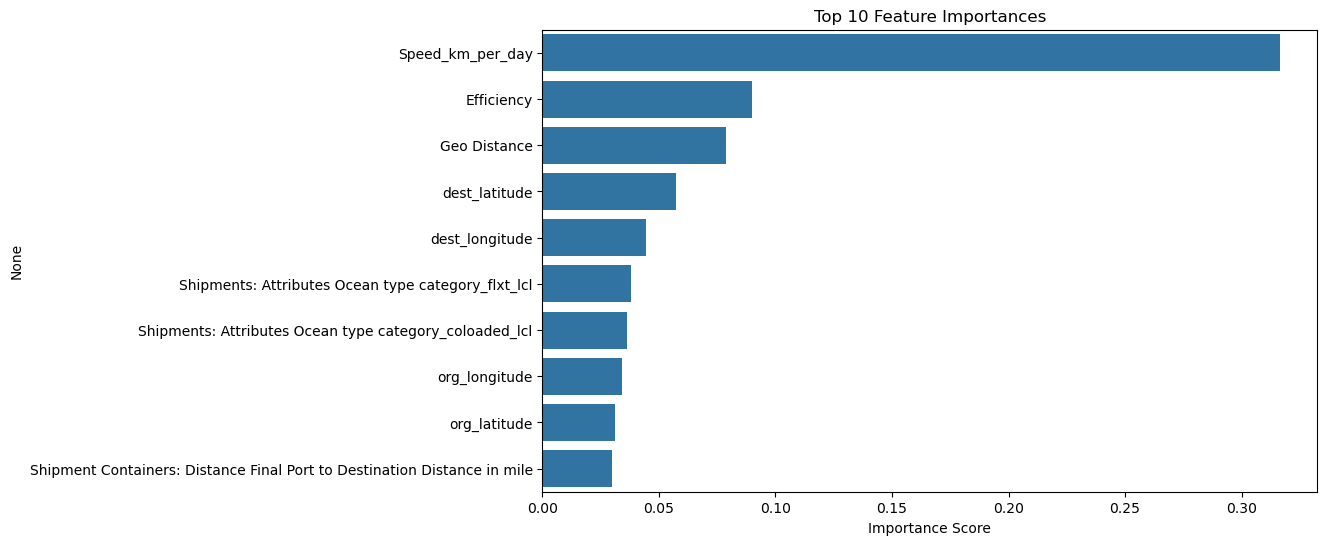

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.Series(grid.feature_importances_, index=X.columns)
top_features = feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.show()


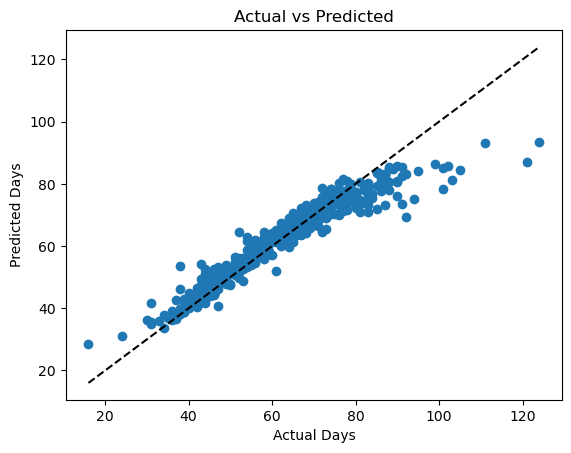

In [23]:
errors = y_test - preds
plt.scatter(y_test, preds)
plt.xlabel("Actual Days")
plt.ylabel("Predicted Days")
plt.title("Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()


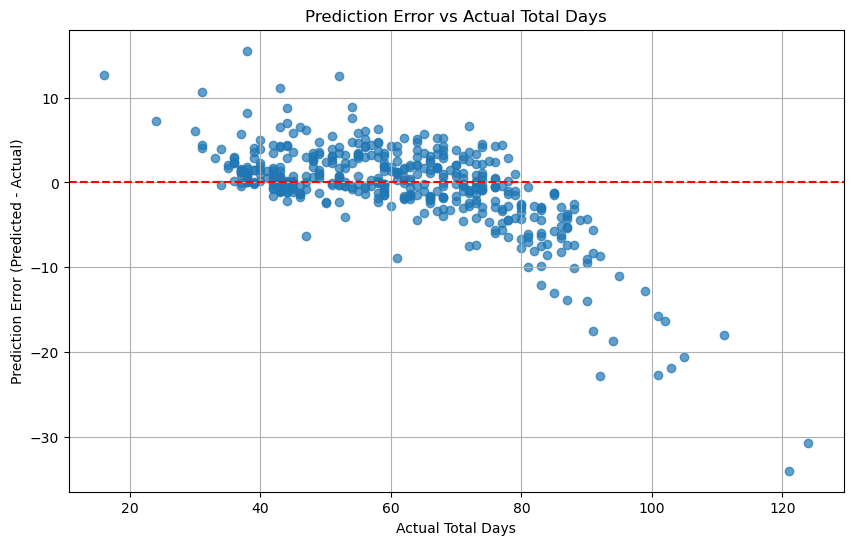

In [24]:
import matplotlib.pyplot as plt

# Calculate residuals (prediction errors)
residuals = preds - y_test

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Line at y=0 for reference
plt.xlabel("Actual Total Days")
plt.ylabel("Prediction Error (Predicted - Actual)")
plt.title("Prediction Error vs Actual Total Days")
plt.grid(True)
plt.show()
